A simple local circuit with interacting populations of excitatory and inhibitory neurons. - Sean Froudist-Walsh & Daniel Margulies. March 2019

In [1]:
# let's get what we need together
from __future__ import division
import numpy as np
import numpy.matlib
import matplotlib.pyplot as plt
%matplotlib inline
import pandas
import scipy.io as sio
import brian2
import os
import copy

/Users/seanfw/miniconda2/lib/python2.7/site-packages/brian2/core/variables.py:174: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  return np.issubdtype(np.bool, self.dtype)


Define the function that transforms input current to changes in firing rate for excitatory neurons (Abbott and Chance, 2005). 
<br>
$$r_E = \frac{aI_{syn,E} - b}{1 - e^{-d(aI_{syn,E} - b)}} $$

Update the firing rates of the interneurons using a threshold linear input/output function
$$ \begin{cases}
  r_I = \frac{1}{g_2}(c_II_{syn,I} - c_0) + r_0 & \text{for } r_I\ge 0\\    
  r_I = 0     & \text{otherwise }  
\end{cases} $$


In [2]:
def current_to_frequency(input_current,population_type,parameters):
    if population_type == 'E':
        a = parameters['a_E']
        b = parameters['b_E']
        d = parameters['d_E']
        return np.divide((a*input_current - b),(1 - np.exp(-d*(a*input_current - b))))
    if population_type == 'I':
        c_I = parameters['c_I']
        r_0 = parameters['r0_I']
        r = np.maximum(c_I*input_current + r_0,0)
        return r

Define the NMDA derivative
<br>
$$ \frac{dS_{NMDA}}{dt} = -\frac{S_{NMDA}}{\tau_{NMDA}} + (1 - S_{NMDA})\gamma r_E$$
(Wong & Wang, 2006)

In [3]:
def NMDA_deriv(S_NMDA_prev,rate_now,parameters):
    
    return -S_NMDA_prev/parameters['tau_NMDA'] + parameters['gam']*(1 - S_NMDA_prev)*rate_now

Define the GABA derivative
<br>
$$ \frac{dS_{GABA}}{dt} = -\frac{S_{GABA}}{\tau_{GABA}} + \gamma_Ir_I$$
(Wong & Wang, 2006)

In [37]:
def GABA_deriv(S_GABA_prev,rate_now,parameters):

    return -S_GABA_prev/parameters['tau_GABA'] + rate_now 


Let's choose the parameters for the model

In [65]:
parameters = {}


parameters.update({ # Time constants
                    'tau_NMDA': 0.06   * brian2.second,    # s 
                    'tau_AMPA': 0.002   * brian2.second,    # s 
                    'tau_GABA': 0.005  * brian2.second,    # s 
                    'tau_rates': 0.002 * brian2.second,    # s 
    
                    # f-I curve parameters - E populations
                    'a_E': 270.  * brian2.Hz/brian2.nA,  # Hz/nA
                    'b_E': 108.  * brian2.Hz,            # Hz
                    'd_E': 0.154 * brian2.second,        # s
                    'gam': 0.641,                         # unitless
    
                    # f-I curve parameters - I populations
                    'c_I': 330 * brian2.Hz/brian2.nA,                 # Hz/nA
                    'r0_I': -95 * brian2.Hz,
    
                    # Strength of connections from E cells
                    'g_E_self': 0.40 * brian2.nA ,        # nA - from E to E
                    'g_IE': 0.23 * brian2.nA ,            # nA - from E to I
    
                    # Strength of connections from I cells
                    'g_I_self': -0.15   * brian2.nA,     # nA  - from I to I
                    'g_EI': -0.3   * brian2.nA,     # nA  - from I to E
    
                    # Background inputs
                    'I0_E': 0.31     * brian2.nA,           # nA - background onto E population
                    'I0_I': 0.22      * brian2.nA,         # nA - background onto I population
    
                    # Noise std dev
                    'std_noise': 0.01 * brian2.nA,         # nA  - standard deviation of noise input  
    
                    # initial values
                    'r0_E': 5 * brian2.Hz,
            
                    # stimulus strength
                    'stim_strength': 0.2 * brian2.nA


                        })      

######## LOCAL CONNECTIVITY MATRIX ########
J =  np.array([
                [parameters['g_E_self'] , parameters['g_EI']],
                [parameters['g_IE'] , parameters['g_I_self']]
    
              ]) * brian2.amp

pops = ['E','I']
pops_column_list  = ['from '+ mystring for mystring in pops]
pops_row_list  = ['to '+ mystring for mystring in pops]

J_NMDA = J*((J>0).astype(np.int))
J_GABA = J*((J<0).astype(np.int))

df_J = pandas.DataFrame(J , columns=pops_column_list, index=pops_row_list)

num_pops  = J.shape[0]

# Choose initial values for rates and synapse variables
R0 = np.array([parameters['r0_E'],parameters['r0_E']]) * brian2.Hz
S_NMDA0 = np.zeros((num_pops))
S_GABA0 = np.zeros((num_pops))

print(J_GABA)

[[   0. -300.]
 [   0. -150.]] pA


Set up simulation details

In [66]:
# Set up simulation parameters
dt=0.5 * brian2.ms  # timestep 
trial_length=5000 * brian2.ms # trial length (s)
num_iterations = int(trial_length/dt)
time = np.arange(0, trial_length, dt)


# Preassign rate and synapse matrices
R           = np.zeros((num_iterations,num_pops)) * brian2.Hz
R[0,:]      = R0
S_NMDA      = np.zeros((num_iterations,num_pops))
S_NMDA[0,:] = S_NMDA0
S_GABA      = np.zeros((num_iterations,num_pops))
S_GABA[0,:] = S_GABA0

# # Preassign external inputs
I_ext        = np.zeros((num_iterations,num_pops)) * brian2.amp
stim_on      = 1 * brian2.second #s
stim_off     = 1.5 * brian2.second #s
distract_on  = 2 * brian2.second #s
distract_off = 2.5 * brian2.second #s

# Let's apply external stimulation to V1 populations E1 & E2
I_ext[int(stim_on/dt):int(stim_off/dt),pops.index('E')] = parameters['stim_strength']

# Create matrices in which we can store the currents
I_local_NMDA =  np.zeros((num_iterations,num_pops)) * brian2.pA
I_local_GABA =  np.zeros((num_iterations,num_pops)) * brian2.pA
I_total      =  np.zeros((num_iterations,num_pops)) * brian2.pA
I_noise      =  np.zeros((num_pops )) *brian2.pA

# # Define background inputs
I_0 = np.zeros((num_pops)) * brian2.pA
I_0[pops.index('E')] = parameters['I0_E']
I_0[pops.index('I')] = parameters['I0_I']

# Let's set up the noise. We will model the noise as an Ornstein-Uhlenbeck process.

# Gaussian noise. mean 0, std 1. Dims: timesteps, local populations, areas
eta = np.random.normal(loc=0.0, scale=1.0, size=(num_iterations,num_pops ))

# prepare the right hand side of the above equation
noise_rhs = eta*((np.sqrt(parameters['tau_AMPA']*np.power(parameters['std_noise'],2))*np.sqrt(dt))/parameters['tau_AMPA'])

print(I_noise)



[0. 0.] A


Text(0,0.5,'firing rate (Hz)')

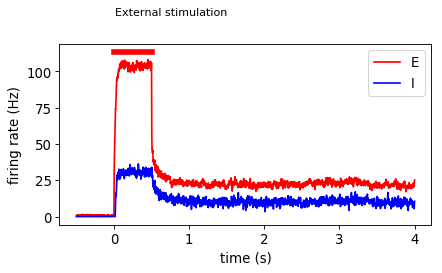

In [67]:
# Run the simulation
for i_t in range(1,num_iterations):

    # update noise - dims = num local pops x num areas
    I_noise = I_noise + -I_noise*(dt/parameters['tau_AMPA']) + noise_rhs[i_t-1,:]

    # local NMDA
    I_local_NMDA[i_t-1,:] = J_NMDA.dot(S_NMDA[i_t-1,:].T).T

    # sum up all the local GABA current onto E and I cell somas
    I_local_GABA[i_t-1,:] = J_GABA.dot(S_GABA[i_t-1,:].T).T

    # Define total input current as sum of local NMDA & GABA inputs, with background, external currents & noise 
    I_total[i_t-1,:] = I_local_NMDA[i_t-1,:] +  I_local_GABA[i_t-1,:] + I_0 + I_ext[i_t-1,:] + I_noise

    # Update the firing rates of the excitatory population
    R[i_t,0] = R[i_t-1,0] + dt*current_to_frequency(I_total[i_t-1,0],'E',parameters)/parameters['tau_rates']-dt*R[i_t-1,0]/parameters['tau_rates']

    # Update the firing rates of the inhibitory population. 
    R[i_t,1] = R[i_t-1,1] + dt*current_to_frequency(I_total[i_t-1,1],'I',parameters)/parameters['tau_rates'] -dt*R[i_t-1,1]/parameters['tau_rates']

    # Update the NMDA synapses
    S_NMDA[i_t,0] = S_NMDA[i_t-1,0] + dt*NMDA_deriv(S_NMDA[i_t-1,0],R[i_t,0],parameters)

    # Update the GABA synapses
    S_GABA[i_t,1] = S_GABA[i_t-1,1] + dt*GABA_deriv(S_GABA[i_t-1,1],R[i_t,1],parameters)
    
    
fig=plt.figure(figsize=(6,3), dpi= 80, facecolor='w', edgecolor='k')
start_time = 0.5 #seconds
end_time = 5 #seconds
plt.rcParams.update({'font.size': 12})

# Plot E population rates
plt.plot(np.arange((start_time-1)*brian2.second,(end_time-1)*brian2.second,dt),R[np.arange(int(start_time/dt),int(end_time/dt),1),0],color='r')
# Plot I population rates
plt.plot(np.arange((start_time-1)*brian2.second,(end_time-1)*brian2.second,dt),R[np.arange(int(start_time/dt),int(end_time/dt),1),1],color='b')
     
# Plot the stimulation time
plt.plot([stim_on-1*brian2.second,stim_off-1*brian2.second],[np.max(R+0.05*np.max(R)),np.max(R+0.05*np.max(R))],color='r',linewidth=5.0)

# place text above the stimulation line
axes = plt.gca()
axes.text(0.15, 1.2,'External stimulation', transform=axes.transAxes, fontsize=10, verticalalignment='top')

plt.legend(['E','I'])
plt.xlabel('time (s)')
plt.ylabel('firing rate (Hz)')
# plt.ylim(0, 80) 
